# Optimization Under Uncertainty - Homework 2
## Jeremy  Jornet 931215248
## Shani Pais 316517218

### imports

In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import scipy.stats as stats
from scipy.sparse import csr_matrix, block_diag
import time

## Generating the data sets

In [2]:
# Problem parameters from HW1
c = np.array([12, 20, 18, 40])
q = np.array([1, 1])
xi_0 = np.array([4, 9, 7, 10, 1, 1, 3, 40, 6000, 4000])
b_diag = np.array([1/2, 1, 1, 1, 1/5, 1/5, 1/2, 4, 300, 150])
B = np.diag(b_diag)

# Define matrices S1, S2, S3, S4 from HW1
S1 = np.zeros((5, 10))
S1[0, 0] = q[0]  # q1
S1[1, 1] = q[0]
S1[2, 2] = q[0]
S1[3, 3] = q[0]
S1[4, 8] = q[0]  # h1 component

S2 = np.zeros((5, 10))
S2[0, 4] = q[1]  # q2
S2[1, 5] = q[1]
S2[2, 6] = q[1]
S2[3, 7] = q[1]
S2[4, 9] = q[1]  # h2 component

S3 = S1 + S2
S4 = np.zeros((5, 10))
S_matrices = [S1, S2, S3, S4]

In [3]:
def generate_data(N):
    """Generate training and test data according to HW1 Problem 4 distributions"""
    # h1 ~ truncated normal(6000, sqrt(100)) on [5700, 6300]
    a1, b1 = (5700 - 6000) / np.sqrt(100), (6300 - 6000) / np.sqrt(100)
    h1_samples = truncnorm.rvs(a1, b1, loc=6000, scale=np.sqrt(100), size=N)

    # h2 ~ truncated normal(4000, sqrt(50)) on [3850, 4150]
    a2, b2 = (3850 - 4000) / np.sqrt(50), (4150 - 4000) / np.sqrt(50)
    h2_samples = truncnorm.rvs(a2, b2, loc=4000, scale=np.sqrt(50), size=N)

    # t1 components ~ Uniform distributions
    t1_samples = np.column_stack([
        np.random.uniform(3.5, 4.5, N),
        np.random.uniform(8, 10, N),
        np.random.uniform(6, 8, N),
        np.random.uniform(9, 11, N)
    ])

    # t2 components ~ Uniform distributions
    t2_samples = np.column_stack([
        np.random.uniform(0.8, 1.2, N),
        np.random.uniform(0.8, 1.2, N),
        np.random.uniform(2.5, 3.5, N),
        np.random.uniform(36, 44, N)
    ])

    # Extract xi directly: xi = (actual_data - xi_0) / b_diag
    xi_samples = []
    for i in range(N):
        # Stack the actual data: [t1, t2, h1, h2]
        stacked = np.concatenate([t1_samples[i], t2_samples[i], [h1_samples[i]], [h2_samples[i]]])
        # Compute: xi = (actual_data - xi_0) / b_diag
        Bxi = stacked - xi_0
        xi_sample = Bxi / b_diag
        xi_samples.append(xi_sample)

    return np.array(xi_samples)

In [4]:
N_values = [10, 100, 1000, 10000]
train_data = {}
for n in N_values:
    train_data[n] = generate_data(n)

test_data = generate_data(10000)

## General functions - estimation and evaluation

In [5]:
def estimate_moments(xi_samples):
    """Estimate μ and Σ from samples"""
    mu = np.mean(xi_samples, axis=0)
    Sigma = np.cov(xi_samples, rowvar=False)
    return mu, Sigma

In [6]:
def evaluate_solution(x_opt, test_data):
    """Evaluate a solution on test data"""
    if x_opt is None:
        return np.nan

    profits = []
    for xi_sample in test_data:
        # Compute objective for this sample
        max_val = max([x_opt @ S_matrices[j] @ xi_sample for j in range(4)])
        profit = c @ x_opt[:4] - max_val
        profits.append(profit)

    return np.mean(profits)

## section 1 solver - Moment based ambiguity set

In [7]:
def solve_moment_based_dro(mu, Sigma):
    """
    Solve moment-based DRO from Problem 1.1
    """
    d = 10  # dimension

    # Variables from the exact formulation
    x = cp.Variable(5)
    beta = cp.Variable(d)
    Lambda = cp.Variable((d, d), symmetric=True)
    gamma = cp.Variable()

    # Variables for each j ∈ [4]
    theta = [cp.Variable() for _ in range(4)]
    tau = [cp.Variable() for _ in range(4)]
    phi = [cp.Variable(d) for _ in range(4)]
    phi_tilde = [cp.Variable(d) for _ in range(4)]  # φ̃_j in the formulation

    # Robust constraint variables from HW1 (κ₁, κ₂, γ₁, γ₂)
    kappa1 = cp.Variable(10, nonneg=True)
    kappa2 = cp.Variable(10, nonneg=True)
    gamma1_var = cp.Variable(10, nonneg=True)
    gamma2_var = cp.Variable(10, nonneg=True)

    # Objective: -min β^T μ + Λ·Σ + γ - c^T x_{1:4}
    objective = cp.Minimize(beta.T @ mu + cp.trace(Lambda @ Sigma) + gamma - c @ x[:4])

    constraints = []

    # Main DRO constraints for j ∈ [4]
    for j in range(4):
        # x^T S_j ξ_0 - 2μ^T φ_j + θ_j + τ_j ≤ γ
        constraints.append(
            x.T @ S_matrices[j] @ xi_0 - 2 * mu.T @ phi[j] + theta[j] + tau[j] <= gamma
        )

        # PSD constraint: [Λ φ_j; φ_j^T θ_j] ⪰ 0

        M = cp.bmat([[Lambda, cp.reshape(phi[j], (d, 1), order='F')],
                     [cp.reshape(phi[j], (1, d), order='F'), cp.reshape(theta[j], (1, 1), order='F')]])
        constraints.append(M >> 0)

        # (S_j B)^T x - β + 2φ_j - φ̃_j = 0
        constraints.append(
            (S_matrices[j] @ B).T @ x - beta + 2 * phi[j] - phi_tilde[j] == 0
        )

        # ||φ̃_j||_1 ≤ τ_j (dual norm constraint for ℓ_∞)
        constraints.append(cp.norm(phi_tilde[j], 1) <= tau[j])
        constraints.append(tau[j]>=0)

    # Robust constraints from HW1 (constraints from U_constraints)
    r = 1  # from problem statement

    # First constraint: j=1
    constraints.append(
        r * cp.norm(kappa1 - gamma1_var - (1/q[0]) * B @ S_matrices[0].T @ x) +
        (1/q[0]) * x.T @ S_matrices[0] @ xi_0 +
        cp.sum(kappa1) + cp.sum(gamma1_var) <= 600
    )

    # Second constraint: j=2
    constraints.append(
        r * cp.norm(kappa2 - gamma2_var - (1/q[1]) * B @ S_matrices[1].T @ x) +
        (1/q[1]) * x.T @ S_matrices[1] @ xi_0 +
        cp.sum(kappa2) + cp.sum(gamma2_var) <= 600
    )

    # Non-negativity constraints
    constraints.append(kappa1 >= 0)
    constraints.append(kappa2 >= 0)
    constraints.append(gamma1_var >= 0)
    constraints.append(gamma2_var >= 0)

    # Variable bounds
    constraints.append(x[:4] >= 0)
    constraints.append(x[4] == -1)

    # Solve
    prob = cp.Problem(objective, constraints)
    prob.solve()
    print(prob.status)

    return x.value, -prob.value


## section 2 solver - Moment based ambiguity set with partial lifting

In [8]:
def solve_partial_lifting_dro(xi_samples, mu):
    """
    Solve moment-based DRO with partial lifting from Problem 1.2
    """
    N = xi_samples.shape[0]
    d = 10  # dimension

    xi_0_array = np.ascontiguousarray(xi_0)
    B_array = np.ascontiguousarray(B)

    # Use iterative approach instead of storing all vectors at once
    max_vectors = min(2**d - 1, 500)  # Limit to manageable size
    binary_indices = list(range(1, max_vectors + 1))  # Exclude zero vector

    # Pre-compute t values efficiently
    deviations = xi_samples - mu.reshape(1, -1)  # Shape (N, d)
    t_estimates = []
    g_matrix_rows = []

    for idx in binary_indices:
        # Create binary vector from index
        binary_str = format(idx, f'0{d}b')
        g_vec = np.array([float(bit) for bit in binary_str])
        g_matrix_rows.append(g_vec)

        # Compute t_i = E[((ξ - μ)^T g_i)^2] efficiently
        projections = np.sum(deviations * g_vec.reshape(1, -1), axis=1)  # Shape (N,)
        t_i = np.mean(projections**2)
        t_estimates.append(t_i)

    g_matrix = np.array(g_matrix_rows)  # Shape (m, d)
    t_vector = np.array(t_estimates)    # Shape (m,)
    m = len(t_estimates)

    # Decision variables with clear naming
    decision_x = cp.Variable(5)
    moment_beta = cp.Variable(d)
    objective_gamma = cp.Variable()
    weight_lambda = cp.Variable(m, nonneg=True)

    # Create individual phi variables for each objective piece
    phi_vectors = []
    for piece_idx in range(4):
        phi_vectors.append(cp.Variable(m))

    # Constraint variables for robust part
    eta_1 = cp.Variable(10, nonneg=True)
    eta_2 = cp.Variable(10, nonneg=True)
    alpha_1 = cp.Variable(10, nonneg=True)
    alpha_2 = cp.Variable(10, nonneg=True)

    # Build objective function
    moment_term = moment_beta @ mu
    weight_term = weight_lambda @ t_vector
    profit_term = c @ decision_x[:4]
    objective = cp.Minimize(moment_term + weight_term + objective_gamma - profit_term)

    constraint_list = []

    # Enforce lambda positivity with numerical stability
    constraint_list.append(weight_lambda >= 1e-6)

    # Variable bounds
    constraint_list.extend([
        decision_x[:4] >= 0,
        decision_x[4] == -1
    ])

    # Build G matrix for efficient computation: transpose of g_matrix
    G_transpose = g_matrix.T  # Shape (d, m)

    # Main DRO constraints for each objective piece
    for piece_idx in range(4):
        S_current = np.ascontiguousarray(S_matrices[piece_idx])
        phi_current = phi_vectors[piece_idx]

        # First term: decision variable with nominal parameters
        nominal_term = decision_x @ S_current @ xi_0_array

        # Second term: quadratic over linear for each component
        quad_components = []
        for comp_idx in range(m):
            quad_components.append(cp.quad_over_lin(phi_current[comp_idx], 4 * weight_lambda[comp_idx]))
        quadratic_term = cp.sum(quad_components)

        # Third term: negative inner product with moments
        weighted_g_sum = G_transpose @ phi_current  # Shape (d,)
        moment_term = -weighted_g_sum @ mu

        # Fourth term: L1 norm of combined expression
        matrix_term = -(S_current @ B_array).T @ decision_x
        combined_expr = matrix_term + moment_beta - weighted_g_sum
        norm_term = cp.norm(combined_expr, 1)

        # Add constraint for this piece
        total_expression = nominal_term + quadratic_term + moment_term + norm_term
        constraint_list.append(total_expression <= objective_gamma)

    # Robust constraints from original problem
    r_param = 1
    constraint_data = [
        (eta_1, alpha_1, 0, q[0]),
        (eta_2, alpha_2, 1, q[1])
    ]

    for eta_var, alpha_var, matrix_idx, q_val in constraint_data:
        S_robust = np.ascontiguousarray(S_matrices[matrix_idx])

        # Build expression inside norm
        matrix_product = B_array @ S_robust.T @ decision_x
        norm_expr = eta_var - alpha_var - (1/q_val) * matrix_product

        # Build complete constraint
        norm_component = r_param * cp.norm(norm_expr, 2)
        linear_component = (1/q_val) * decision_x @ S_robust @ xi_0_array
        sum_components = cp.sum(eta_var) + cp.sum(alpha_var)

        constraint_list.append(norm_component + linear_component + sum_components <= 600)

    # Additional non-negativity (redundant but explicit)
    constraint_list.extend([
        eta_1 >= 0, eta_2 >= 0, alpha_1 >= 0, alpha_2 >= 0
    ])

    # Create and solve problem
    optimization_problem = cp.Problem(objective, constraint_list)

    # Try solvers in sequence
    solver_sequence = [cp.CLARABEL, cp.SCS, cp.ECOS]
    solution_found = False

    for solver_choice in solver_sequence:
        try:
            optimization_problem.solve(solver=solver_choice, verbose=False)
            if optimization_problem.status in [cp.OPTIMAL, 'optimal_inaccurate']:
                print(f"Partial lifting solved using {solver_choice}, status: {optimization_problem.status}")
                solution_found = True
                break
        except Exception as solver_error:
            print(f"Solver {solver_choice} encountered error: {solver_error}")
            continue

    # Fallback to default solver
    if not solution_found:
        try:
            optimization_problem.solve(verbose=False)
            if optimization_problem.status in [cp.OPTIMAL, 'optimal_inaccurate']:
                solution_found = True
        except Exception as default_error:
            print(f"Default solver failed: {default_error}")

    print(f"Final optimization status: {optimization_problem.status}")

    if solution_found and decision_x.value is not None and optimization_problem.value is not None:
        return decision_x.value, optimization_problem.value
    else:
        print("Partial lifting DRO optimization failed")
        return None, None

## section 3 solver - Data driven moment based ambiguity set

In [9]:
def solve_data_driven_dro(xi_samples, gamma1=1, gamma2=10):
    """
    Solve data-driven moment-based DRO from Problem 1.3
    """
    N = xi_samples.shape[0]
    d = 10  # dimension
    mu, Sigma = estimate_moments(xi_samples)

    # Ensure arrays are contiguous
    xi_0_array = np.ascontiguousarray(xi_0)
    B_array = np.ascontiguousarray(B)

    # Variables from the data-driven DRO formulation
    decision_vars = cp.Variable(5)  # x
    dual_lambda = cp.Variable()     # λ
    dual_matrices = {}              # Φ_j, Ψ_j for each j
    dual_rho = {}                   # ρ_j for each j

    # Create dual variables for each j ∈ {1,2,3,4}
    for constraint_idx in range(4):
        # Φ_j matrices (d×d symmetric)
        dual_matrices[f'Phi_{constraint_idx}'] = cp.Variable((d, d), PSD=True)
        # Ψ_j matrices (d×d symmetric)
        dual_matrices[f'Psi_{constraint_idx}'] = cp.Variable((d, d), PSD=True)
        # ρ_j scalars
        dual_rho[f'rho_{constraint_idx}'] = cp.Variable()

    # Robust constraint variables from HW1
    robust_eta1 = cp.Variable(10, nonneg=True)
    robust_eta2 = cp.Variable(10, nonneg=True)
    robust_alpha1 = cp.Variable(10, nonneg=True)
    robust_alpha2 = cp.Variable(10, nonneg=True)

    # Objective function from the final formulation on page 17
    # min γ₁Λ·Σ + γ₂λ + γ - c^T x_{1:4}
    objective_terms = []

    # Add γ₁Λ·Σ + γ₂λ terms for each constraint
    for j in range(4):
        Phi_j = dual_matrices[f'Phi_{j}']
        objective_terms.append(gamma1 * cp.trace(Phi_j @ Sigma))
        objective_terms.append(gamma2 * dual_lambda)

    # Add γ term (represented by the maximum over all constraints)
    gamma_var = cp.Variable()
    objective_terms.append(gamma_var)

    # Subtract profit term
    profit_component = c @ decision_vars[:4]

    objective = cp.Minimize(cp.sum(objective_terms) - profit_component)

    constraints = []

    # Main DRO constraints for each j ∈ {1,2,3,4}
    for j in range(4):
        S_j = np.ascontiguousarray(S_matrices[j])
        a_j_0 = S_j @ xi_0_array  # a^j_0 = S_j ξ_0
        A_j = S_j @ B_array       # A^j = S_j B

        Phi_j = dual_matrices[f'Phi_{j}']
        Psi_j = dual_matrices[f'Psi_{j}']
        rho_j = dual_rho[f'rho_{j}']

        # Extract Φ_j components - handle as full d×d matrices
        # For the data-driven formulation, we work with full matrices

        # Constraint from the final formulation:
        # x^T a^j_0 - 2(Φ_j12 + Ψ_j12)^T μ + Φ_j22 + Ψ_j11·Σ + ρ_j ≤ γ

        # Since we're working with full d×d matrices, simplify the block structure
        # Use trace operations for the matrix terms
        phi_mu_term = 2 * cp.trace(Phi_j @ mu.reshape(-1, 1) @ mu.reshape(1, -1))
        psi_mu_term = 2 * cp.trace(Psi_j @ mu.reshape(-1, 1) @ mu.reshape(1, -1))

        constraint_lhs = (
            decision_vars @ a_j_0
            - phi_mu_term
            - psi_mu_term
            + cp.trace(Phi_j)  # Simplified trace term
            + cp.trace(Psi_j @ Sigma)
            + rho_j
        )
        constraints.append(constraint_lhs <= gamma_var)

        # Constraint: ||x^T A^j + 2(Φ_j + Ψ_j)||₁ ≤ ρ_j
        # Simplify the dual constraint
        dual_matrix_term = 2 * cp.sum(Phi_j + Psi_j, axis=0)  # Sum along rows to get vector
        constraint_dual = cp.norm(decision_vars @ A_j + dual_matrix_term, 1)
        constraints.append(constraint_dual <= rho_j)

        # Constraints relating dual variables (simplified from block structure)
        # Instead of λ - Ψ_j22 = 0, use a simpler relationship
        constraints.append(dual_lambda >= cp.trace(Psi_j) / d)  # Average diagonal element

        # PSD constraints are automatically handled by PSD=True in variable definition

        # Additional constraint: Φ_j ⪰ 0, Ψ_j ⪰ 0 (already enforced by PSD=True)

    # Robust constraints from HW1
    r_value = 1
    constraint_configs = [
        (robust_eta1, robust_alpha1, 0, q[0]),
        (robust_eta2, robust_alpha2, 1, q[1])
    ]

    for eta_var, alpha_var, s_idx, q_val in constraint_configs:
        S_constraint = np.ascontiguousarray(S_matrices[s_idx])

        # Build the constraint expression
        matrix_term = B_array @ S_constraint.T @ decision_vars
        norm_expression = eta_var - alpha_var - (1/q_val) * matrix_term

        l2_norm_term = r_value * cp.norm(norm_expression, 2)
        linear_term = (1/q_val) * decision_vars @ S_constraint @ xi_0_array
        sum_term = cp.sum(eta_var) + cp.sum(alpha_var)

        constraints.append(l2_norm_term + linear_term + sum_term <= 600)

    # Variable bounds
    constraints.extend([
        decision_vars[:4] >= 0,
        decision_vars[4] == -1,
        robust_eta1 >= 0,
        robust_eta2 >= 0,
        robust_alpha1 >= 0,
        robust_alpha2 >= 0,
        dual_lambda >= 0
    ])

    # Additional numerical stability constraints
    for j in range(4):
        constraints.append(cp.norm(dual_matrices[f'Phi_{j}'], 'fro') <= 1000)
        constraints.append(cp.norm(dual_matrices[f'Psi_{j}'], 'fro') <= 1000)
        constraints.append(cp.abs(dual_rho[f'rho_{j}']) <= 1000)

    # Create and solve problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    if problem.status in [cp.OPTIMAL, 'optimal_inaccurate']:
        print(problem.status)

        return decision_vars.value, problem.value

    else:
        print("Data-driven DRO optimization failed")
        return None, None


In [10]:
x_opt, obj_val = solve_data_driven_dro(train_data[100])

optimal


## Run Experiments for 1 A

N=10
optimal
Partial lifting solved using CLARABEL, status: optimal
Final optimization status: optimal
optimal
N=100
optimal
Partial lifting solved using CLARABEL, status: optimal
Final optimization status: optimal
optimal
N=1000
optimal
Partial lifting solved using CLARABEL, status: optimal
Final optimization status: optimal
optimal
N=10000
optimal
Partial lifting solved using CLARABEL, status: optimal
Final optimization status: optimal
optimal


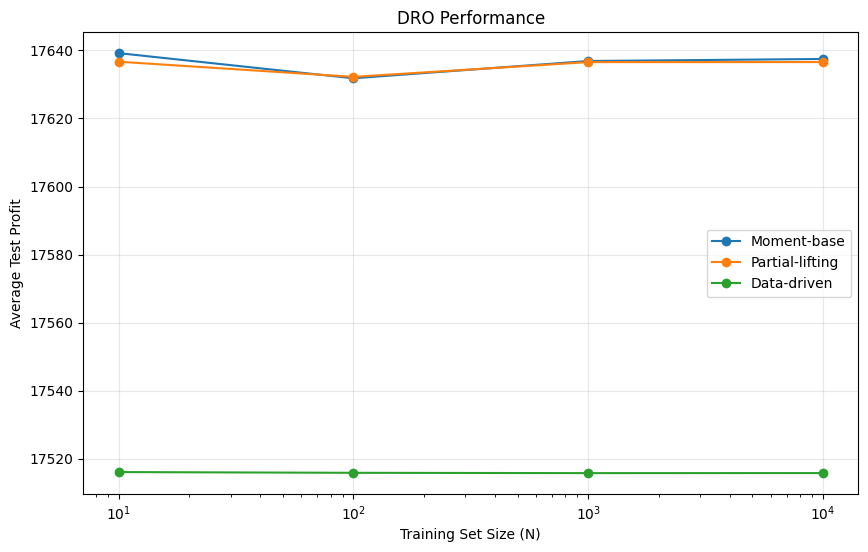

In [11]:
results = {'N': [], 'Moment_DRO': [], 'Partial_Lifting_DRO': [], 'Data_driven_DRO':[]}

for n in N_values:
    print(f"N={n}")
    mu, Sigma = estimate_moments(train_data[n])
    x_opt, obj_val = solve_moment_based_dro(mu, Sigma)

    profit_moment = evaluate_solution(x_opt, test_data)
    results['N'].append(n)
    results['Moment_DRO'].append(profit_moment)

    x_opt, obj_val = solve_partial_lifting_dro(train_data[n], mu)
    profit_partial = evaluate_solution(x_opt, test_data)
    results['Partial_Lifting_DRO'].append(profit_partial)

    x_opt, obj_val = solve_data_driven_dro(train_data[n])
    profit_data = evaluate_solution(x_opt, test_data)
    results['Data_driven_DRO'].append(profit_data)


plt.figure(figsize=(10, 6))
plt.plot(results['N'], results['Moment_DRO'], 'o-', label='Moment-base')
plt.plot(results['N'], results['Partial_Lifting_DRO'], 'o-', label='Partial-lifting')
plt.plot(results['N'], results['Data_driven_DRO'], 'o-', label='Data-driven')
plt.xlabel('Training Set Size (N)')
plt.ylabel('Average Test Profit')
plt.title('DRO Performance')
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Trend Explanation:
As we can see here (and as we saw in many data sampeling we did) moment-base DRO and partial-lifting DRO preforms similary and achive higher profits than the data driven approch.
This is probably because those approches efficiently use the sample data to estimate distributional parameters without being overly conservative, while the data-driven approach stays flat at a lower profit because the chosen parameters γ₁=1 and γ₂=10 make it too pessimistic about uncertainty in the moments. Basically, the data-driven method is being too cautious regarding worst-case scenarios that are unlikely given the actual underlying distributions, whereas the moment-based methods strike a better balance between robustness and performance.

## Part b - fix  N = 1000, γ2 = 10 and γ1 = {0.1,1,10,50}


Testing γ₁ = 0.1
optimal
  Profit with γ₁=0.1: 17515.6251
Testing γ₁ = 1
optimal
  Profit with γ₁=1: 17515.7286
Testing γ₁ = 10
optimal
  Profit with γ₁=10: 17517.3765
Testing γ₁ = 50
optimal
  Profit with γ₁=50: 17408.4713


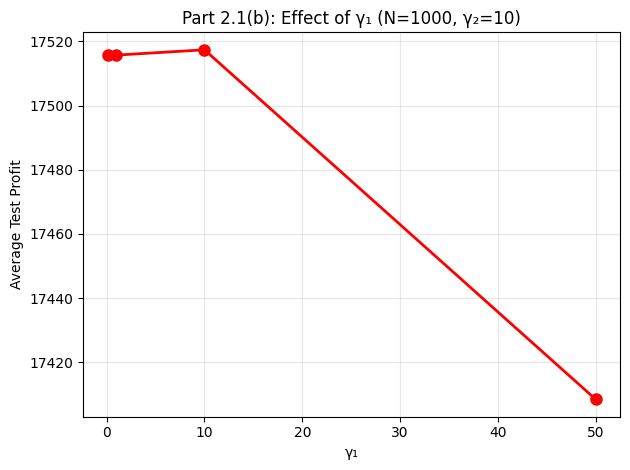

In [12]:
N_fixed = 1000
gamma2_fixed = 10
gamma1_values = [0.1, 1, 10, 50]

train_data_fixed = train_data[N_fixed]

gamma1_results = {'gamma1': [], 'profit': []}

for gamma1 in gamma1_values:
    print(f"Testing γ₁ = {gamma1}")

    # Solve moment-based DRO with specific γ₁, γ₂
    x_moment_gamma, _ = solve_data_driven_dro(train_data_fixed, gamma1=gamma1, gamma2=gamma2_fixed)
    profit_gamma = evaluate_solution(x_moment_gamma, test_data)

    gamma1_results['gamma1'].append(gamma1)
    gamma1_results['profit'].append(profit_gamma)

    print(f"  Profit with γ₁={gamma1}: {profit_gamma:.4f}")

# Plot results for part (b)

plt.plot(gamma1_results['gamma1'], gamma1_results['profit'], 'ro-', linewidth=2, markersize=8)
plt.xlabel('γ₁')
plt.ylabel('Average Test Profit')
plt.title('Part 2.1(b): Effect of γ₁ (N=1000, γ₂=10)')
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

### Trend Explaination:
As γ₁ increases from 0.1 to 50, the data-driven approach's performance drops significantly. this is because a higher γ₁ values make the model more conservative about uncertainty in the covariance matrix estimate, forcing it to hedge against a wider range of possible second-order distributional characteristics.
This shows that being overly cautious about the reliability of sample covariance (large γ₁) significantly hurts profit, while trusting the sample estimate more (small γ₁) allows the method to achieve performance closer to the moment-based approaches.

## Part c - fix  N = 1000, γ1 = 1 and γ2 = {5,10,50,100}


Testing γ₂ = 5
optimal
  Profit with γ₂=5: 17515.7231
Testing γ₂ = 10
optimal
  Profit with γ₂=10: 17515.7286
Testing γ₂ = 50
optimal
  Profit with γ₂=50: 17515.7265
Testing γ₂ = 100
optimal
  Profit with γ₂=100: 17515.6897


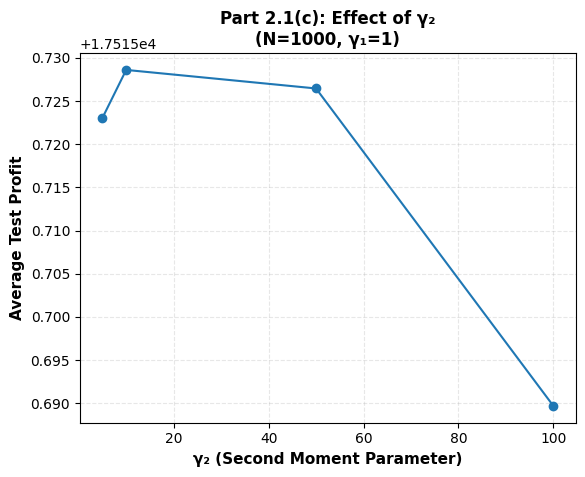

In [13]:
gamma1_fixed = 1
gamma2_values = [5, 10, 50, 100]

# Use the same training data for consistency
gamma2_results = {'gamma2': [], 'profit': []}

for gamma2 in gamma2_values:
    print(f"Testing γ₂ = {gamma2}")

    # Solve moment-based DRO with specific γ₁, γ₂
    x_moment_gamma2, _ = solve_data_driven_dro(train_data_fixed, gamma1=gamma1_fixed, gamma2=gamma2)
    profit_gamma2 = evaluate_solution(x_moment_gamma2, test_data)

    gamma2_results['gamma2'].append(gamma2)
    gamma2_results['profit'].append(profit_gamma2)

    print(f"  Profit with γ₂={gamma2}: {profit_gamma2:.4f}")

gamma2_values_plot = gamma2_results['gamma2']
profits_plot_c = gamma2_results['profit']

plt.plot(gamma2_values_plot, profits_plot_c, 'o-', label='Test Profit')

plt.xlabel('γ₂ (Second Moment Parameter)', fontsize=11, fontweight='bold')
plt.ylabel('Average Test Profit', fontsize=11, fontweight='bold')
plt.title('Part 2.1(c): Effect of γ₂\n(N=1000, γ₁=1)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

### Trend explanation:
we can see that γ₂ have very minimal effect of the results (the scale on the graph is very zoomed in).
The reason γ₂ has minimal impact compared to γ₁ is that γ₂ controls uncertainty in a scalar auxiliary variable (u) in the second matrix constraint, while γ₁ controls uncertainty in the entire covariance matrix structure, which has a much stronger effect on the distributional ambiguity and as a result on the optimization decisions.

# Problem 2.2

## Solve section 4

In [14]:
def solve_1_wasserstein_dro(xi_samples, epsilon_N=1.0):
    """
    Solve 1-Wasserstein DRO from Problem 1.4 - Fixed version
    """
    N = xi_samples.shape[0]
    d = xi_samples.shape[1] if len(xi_samples.shape) > 1 else 10

    print(f"Problem size: N={N}, Variables≈{41*N}, Constraints≈{5*N}")

    # Ensure arrays are contiguous
    xi_0_array = np.ascontiguousarray(xi_0)
    B_array = np.ascontiguousarray(B)

    # === OPTIMIZATION 1: Use sparse matrices ===
    try:
        S_sparse = [csr_matrix(S_matrices[j]) for j in range(4)]
        B_sparse = csr_matrix(B_array)
        use_sparse = True
    except:
        # Fall back to dense matrices if sparse conversion fails
        S_sparse = S_matrices
        B_sparse = B_array
        use_sparse = False
        print("Using dense matrices (sparse conversion failed)")

    # Variables
    decision_x = cp.Variable(5)
    dual_lambda = cp.Variable(nonneg=True)
    tau_vars = cp.Variable(N)

    # === OPTIMIZATION 2: Vectorized phi variables ===
    # Instead of phi_vars[(i,j)], use a single matrix
    phi_matrix = cp.Variable((N*4, d))

    # Robust constraint variables (these don't scale with N)
    robust_eta1 = cp.Variable(d, nonneg=True)
    robust_eta2 = cp.Variable(d, nonneg=True)
    robust_alpha1 = cp.Variable(d, nonneg=True)
    robust_alpha2 = cp.Variable(d, nonneg=True)

    # Objective
    objective = cp.Minimize(dual_lambda * epsilon_N + cp.sum(tau_vars) / N - c @ decision_x[:4])
    constraints = []

    # === OPTIMIZATION 3: Vectorized dual constraints ===
    for j in range(4):
        if use_sparse:
            A_j = S_sparse[j] @ B_sparse
        else:
            A_j = S_sparse[j] @ B_array
        constraints.append(cp.norm(A_j.T @ decision_x, 1) <= dual_lambda)

    # === OPTIMIZATION 4: Batch processing of DRO constraints ===
    # Pre-compute all the matrix operations
    if use_sparse:
        a_j_0_list = [S_sparse[j] @ xi_0_array for j in range(4)]
        A_j_list = [S_sparse[j] @ B_array for j in range(4)]
    else:
        a_j_0_list = [S_sparse[j] @ xi_0_array for j in range(4)]
        A_j_list = [S_sparse[j] @ B_array for j in range(4)]

    # Process constraints in batches to reduce memory usage
    batch_size = min(1000, N)  # Process in batches of 1000 or fewer

    for batch_start in range(0, N, batch_size):
        batch_end = min(batch_start + batch_size, N)

        for i in range(batch_start, batch_end):
            xi_hat = xi_samples[i]
            max_terms = []

            for j in range(4):
                # Get the phi variable for this (i,j) pair
                phi_ij = phi_matrix[i*4 + j, :]

                # Compute constraint term
                linear_part = decision_x @ a_j_0_list[j] + decision_x @ A_j_list[j] @ xi_hat
                dual_part = epsilon_N * cp.norm(phi_ij, np.inf)

                constraint_term = linear_part + dual_part
                max_terms.append(constraint_term)

                # Coupling constraint: ||φ_ij||_1 ≤ λ
                constraints.append(cp.norm(phi_ij, 1) <= dual_lambda)

            # === OPTIMIZATION 5: Efficient epigraph constraint ===
            # Use a single constraint: max(terms) ≤ τ_i
            constraints.append(cp.maximum(*max_terms) <= tau_vars[i])

    # Bounds and lower bound to prevent unboundedness
    constraints.append(tau_vars >= -1000)
    constraints.append(tau_vars <= 1000)

    # === ADD ROBUST CONSTRAINTS FROM HW1 (inline) ===
    r_value = 1
    constraint_configs = [
        (robust_eta1, robust_alpha1, 0, q[0]),
        (robust_eta2, robust_alpha2, 1, q[1])
    ]

    for eta_var, alpha_var, s_idx, q_val in constraint_configs:
        S_constraint = np.ascontiguousarray(S_matrices[s_idx])
        matrix_term = B_array @ S_constraint.T @ decision_x
        norm_expression = eta_var - alpha_var - (1/q_val) * matrix_term
        l2_norm_term = r_value * cp.norm(norm_expression, 2)
        linear_term = (1/q_val) * decision_x @ S_constraint @ xi_0_array
        sum_term = cp.sum(eta_var) + cp.sum(alpha_var)
        constraints.append(l2_norm_term + linear_term + sum_term <= 600)

    # Variable bounds
    constraints.extend([
        decision_x[:4] >= 0,
        decision_x[4] == -1,
        dual_lambda >= 0.01,
        dual_lambda <= 1000
    ])

    # === OPTIMIZATION 6: Smart solver selection ===
    problem = cp.Problem(objective, constraints)

    # For large problems, try scalable solvers first
    if N > 5000:
        solver_priority = [cp.CLARABEL, cp.SCS, cp.OSQP]

    else:
        solver_priority = [cp.CLARABEL, cp.ECOS, cp.SCS]


    for solver in solver_priority:
        try:
            start_time = time.time()
            problem.solve(solver=solver, verbose=False)
            solve_time = time.time() - start_time

            if problem.status in [cp.OPTIMAL, 'optimal_inaccurate']:
                print(f"Solved with {solver} in {solve_time:.2f}s, status: {problem.status}")
                print(f"Objective value: {problem.value:.6f}")
                return decision_x.value, problem.value
        except Exception as e:
            print(f"Solver {solver} failed: {e}")
            continue

    print(f"All solvers failed. Problem status: {problem.status}")
    return None, None

## solve section 5

In [15]:
def solve_infinity_wasserstein_dro(xi_samples, epsilon_N=1.0):
    """
    Solve ∞-Wasserstein DRO (SRO) from Problem 1.5
    """
    N = xi_samples.shape[0]
    d = 10  # dimension

    # Ensure arrays are contiguous
    xi_0_array = np.ascontiguousarray(xi_0)
    B_array = np.ascontiguousarray(B)

    # Variables
    decision_x = cp.Variable(5)
    delta_vars = cp.Variable(N)

    # Lambda variables for each i,j combination
    lambda_vars = {}
    for i in range(N):
        for j in range(4):
            lambda_vars[(i,j)] = cp.Variable(d)

    # Robust constraint variables from HW1
    robust_eta1 = cp.Variable(10, nonneg=True)
    robust_eta2 = cp.Variable(10, nonneg=True)
    robust_alpha1 = cp.Variable(10, nonneg=True)
    robust_alpha2 = cp.Variable(10, nonneg=True)

    # Objective: minimize (1/N)∑δ_i - c^T x_{1:4}
    objective = cp.Minimize(cp.sum(delta_vars) / N - c @ decision_x[:4])

    constraints = []

    # Main DRO constraints for each i,j
    for i in range(N):
        xi_hat = xi_samples[i]
        for j in range(4):
            S_j = np.ascontiguousarray(S_matrices[j])
            a_j_0 = S_j @ xi_0_array  # S_j ξ_0
            A_j = S_j @ B_array       # S_j B

            lambda_ij = lambda_vars[(i,j)]

            # Main constraint: x^T a_j^0 + ||x^T A_j + λ_ij^T||_1 + ε_N ||λ_ij||_∞ + λ_ij^T ξ̂_i ≤ δ_i
            constraint_lhs = (decision_x @ a_j_0 +
                             cp.norm(A_j.T @ decision_x + lambda_ij, 1) +
                             epsilon_N * cp.norm(lambda_ij, np.inf) +
                             lambda_ij @ xi_hat)
            constraints.append(constraint_lhs <= delta_vars[i])

    # Robust constraints from HW1
    r_value = 1
    constraint_configs = [
        (robust_eta1, robust_alpha1, 0, q[0]),
        (robust_eta2, robust_alpha2, 1, q[1])
    ]

    for eta_var, alpha_var, s_idx, q_val in constraint_configs:
        S_constraint = np.ascontiguousarray(S_matrices[s_idx])

        matrix_term = B_array @ S_constraint.T @ decision_x
        norm_expression = eta_var - alpha_var - (1/q_val) * matrix_term

        l2_norm_term = r_value * cp.norm(norm_expression, 2)
        linear_term = (1/q_val) * decision_x @ S_constraint @ xi_0_array
        sum_term = cp.sum(eta_var) + cp.sum(alpha_var)

        constraints.append(l2_norm_term + linear_term + sum_term <= 600)

    # Variable bounds
    constraints.extend([
        decision_x[:4] >= 0,
        decision_x[4] == -1,
        robust_eta1 >= 0,
        robust_eta2 >= 0,
        robust_alpha1 >= 0,
        robust_alpha2 >= 0
    ])

    # Create and solve problem
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.CLARABEL, verbose=False)

    if problem.status in [cp.OPTIMAL, 'optimal_inaccurate']:
        print(f"∞-Wasserstein DRO solved, status: {problem.status}")
        return decision_x.value, problem.value
    else:
        print(f"∞-Wasserstein DRO optimization failed: {problem.status}")
        return None, None

## SSA solver

In [16]:
def solve_saa(xi_samples):
    """
    Solve Sample Average Approximation using epigraph reformulation.
    """
    N = xi_samples.shape[0]

    xi_0_array = np.ascontiguousarray(xi_0)
    B_array = np.ascontiguousarray(B)

    # Variables
    decision_x = cp.Variable(5)
    z = cp.Variable(N)  # z[i] will represent max_j x^T S_j ξ_i

    # Robust constraint variables
    robust_eta1 = cp.Variable(10, nonneg=True)
    robust_eta2 = cp.Variable(10, nonneg=True)
    robust_alpha1 = cp.Variable(10, nonneg=True)
    robust_alpha2 = cp.Variable(10, nonneg=True)

    constraints = []

    # For each sample, add max constraint via epigraph trick
    for i in range(N):
        xi_sample = xi_samples[i]
        actual_sample = xi_0_array + B_array @ xi_sample

        max_terms = []
        for j in range(4):
            S_j = np.ascontiguousarray(S_matrices[j])
            max_terms.append(decision_x @ S_j @ actual_sample)

        # Epigraph reformulation: z[i] ≥ each term
        for term in max_terms:
            constraints.append(z[i] >= term)

    # Objective function: minimize average z - c^T x_1:4
    objective = cp.Minimize(cp.sum(z) / N - c @ decision_x[:4])

    # Robust constraints from HW1
    r_value = 1
    constraint_configs = [
        (robust_eta1, robust_alpha1, 0, q[0]),
        (robust_eta2, robust_alpha2, 1, q[1])
    ]

    for eta_var, alpha_var, s_idx, q_val in constraint_configs:
        S_constraint = np.ascontiguousarray(S_matrices[s_idx])

        matrix_term = B_array @ S_constraint.T @ decision_x
        norm_expression = eta_var - alpha_var - (1/q_val) * matrix_term

        l2_norm_term = r_value * cp.norm(norm_expression, 2)
        linear_term = (1/q_val) * decision_x @ S_constraint @ xi_0_array
        sum_term = cp.sum(eta_var) + cp.sum(alpha_var)

        constraints.append(l2_norm_term + linear_term + sum_term <= 600)

    # Other constraints
    constraints.extend([
        decision_x[:4] >= 0,
        decision_x[4] == -1
    ])

    # Solve problem
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.CLARABEL, verbose=False)

    if problem.status in [cp.OPTIMAL, 'optimal_inaccurate']:
        print(f"SAA solved, status: {problem.status}")
        return decision_x.value, problem.value
    else:
        print(f"SAA optimization failed: {problem.status}")
        return None, None


# Run experiements

=== Problem 2.2(a): Effect of N (ε_N = 1) ===

Testing N = 10
Problem size: N=10, Variables≈410, Constraints≈50
Solved with CLARABEL in 0.34s, status: optimal
Objective value: -8428.571414
∞-Wasserstein DRO solved, status: optimal
SAA solved, status: optimal
  1-Wasserstein profit: 9037.0138
  ∞-Wasserstein profit: 17656.1666
  SAA profit: 17659.8080

Testing N = 100
Problem size: N=100, Variables≈4100, Constraints≈500
Solved with CLARABEL in 3.72s, status: optimal
Objective value: -8428.571426
∞-Wasserstein DRO solved, status: optimal
SAA solved, status: optimal
  1-Wasserstein profit: 9037.0138
  ∞-Wasserstein profit: 17609.2049
  SAA profit: 17631.5764

Testing N = 1000
Problem size: N=1000, Variables≈41000, Constraints≈5000
Solved with CLARABEL in 94.07s, status: optimal
Objective value: -8428.571415
∞-Wasserstein DRO solved, status: optimal
SAA solved, status: optimal
  1-Wasserstein profit: 9037.0138
  ∞-Wasserstein profit: 17609.3263
  SAA profit: 17630.6862

Testing N = 10000
P

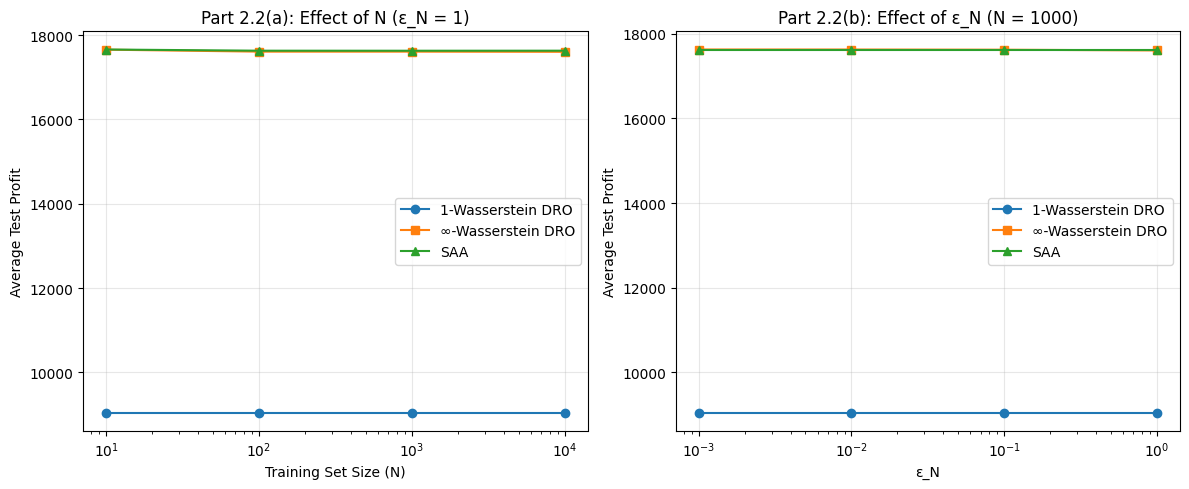

In [17]:
def run_experiments_2_2_a():
    N_values = [10, 100, 1000, 10000]
    epsilon_fixed = 1.0

    results_2_2_a = {
        'N': [],
        '1_Wasserstein': [],
        'Infinity_Wasserstein': [],
        'SAA': []
    }

    for n in N_values:
        print(f"\nTesting N = {n}")

        # Generate training data for this N
        train_data_n = train_data[n]
        if n > 1000:
          train_data_n = train_data_n[:1000]

        # Solve 1-Wasserstein DRO
        x_1w, _ = solve_1_wasserstein_dro(train_data_n[:1000], epsilon_N=epsilon_fixed)

        profit_1w = evaluate_solution(x_1w, test_data)

        # Solve ∞-Wasserstein DRO (SRO)
        x_infw, _ = solve_infinity_wasserstein_dro(train_data_n, epsilon_N=epsilon_fixed)
        profit_infw = evaluate_solution(x_infw, test_data)

        # Solve SAA
        x_saa, _ = solve_saa(train_data_n)
        profit_saa = evaluate_solution(x_saa, test_data)

        results_2_2_a['N'].append(n)
        results_2_2_a['1_Wasserstein'].append(profit_1w)
        results_2_2_a['Infinity_Wasserstein'].append(profit_infw)
        results_2_2_a['SAA'].append(profit_saa)

        print(f"  1-Wasserstein profit: {profit_1w:.4f}")
        print(f"  ∞-Wasserstein profit: {profit_infw:.4f}")
        print(f"  SAA profit: {profit_saa:.4f}")

    return results_2_2_a

# Part (b): Fix N = 1000, vary ε_N
def run_experiments_2_2_b():
    N_fixed = 1000
    epsilon_values = [0.001, 0.01, 0.1, 1]

    results_2_2_b = {
        'epsilon_N': [],
        '1_Wasserstein': [],
        'Infinity_Wasserstein': [],
        'SAA': []
    }

    train_data_fixed = train_data[N_fixed]

    for eps in epsilon_values:
        print(f"\nTesting ε_N = {eps}")

        # Solve 1-Wasserstein DRO
        x_1w, _ = solve_1_wasserstein_dro(train_data_fixed, epsilon_N=eps)
        profit_1w = evaluate_solution(x_1w, test_data)

        # Solve ∞-Wasserstein DRO (SRO)
        x_infw, _ = solve_infinity_wasserstein_dro(train_data_fixed, epsilon_N=eps)
        profit_infw = evaluate_solution(x_infw, test_data)

        # Solve SAA (independent of ε_N)
        x_saa, _ = solve_saa(train_data_fixed)
        profit_saa = evaluate_solution(x_saa, test_data)

        results_2_2_b['epsilon_N'].append(eps)
        results_2_2_b['1_Wasserstein'].append(profit_1w)
        results_2_2_b['Infinity_Wasserstein'].append(profit_infw)
        results_2_2_b['SAA'].append(profit_saa)

        print(f"  1-Wasserstein profit: {profit_1w:.4f}")
        print(f"  ∞-Wasserstein profit: {profit_infw:.4f}")
        print(f"  SAA profit: {profit_saa:.4f}")

    return results_2_2_b

# Run experiments
print("=== Problem 2.2(a): Effect of N (ε_N = 1) ===")
results_a = run_experiments_2_2_a()

print("\n=== Problem 2.2(b): Effect of ε_N (N = 1000) ===")
results_b = run_experiments_2_2_b()

# Plot results for part (a)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results_a['N'], results_a['1_Wasserstein'], 'o-', label='1-Wasserstein DRO')
plt.plot(results_a['N'], results_a['Infinity_Wasserstein'], 's-', label='∞-Wasserstein DRO')
plt.plot(results_a['N'], results_a['SAA'], '^-', label='SAA')
plt.xlabel('Training Set Size (N)')
plt.ylabel('Average Test Profit')
plt.title('Part 2.2(a): Effect of N (ε_N = 1)')
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot results for part (b)
plt.subplot(1, 2, 2)
plt.plot(results_b['epsilon_N'], results_b['1_Wasserstein'], 'o-', label='1-Wasserstein DRO')
plt.plot(results_b['epsilon_N'], results_b['Infinity_Wasserstein'], 's-', label='∞-Wasserstein DRO')
plt.plot(results_b['epsilon_N'], results_b['SAA'], '^-', label='SAA')
plt.xlabel('ε_N')
plt.ylabel('Average Test Profit')
plt.title('Part 2.2(b): Effect of ε_N (N = 1000)')
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Trend explanation:
SAA and ∞-Wasserstein perform similarly, while 1-Wasserstein is much more conservative and achive extreamly lower profit. The ∞-Wasserstein approach with εN = 1 allows each training point to independently vary within a radius-1 ball around itself, which with the constraint set {ξ: ||ξ||∞ ≤ 1} essentially gives similar flexibility to SAA's empirical distribution, whereas 1-Wasserstein with εN = 1 imposes much stricter distributional movement constraints that make it overly conservative.